In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
# Dataset de mnist usado = fashion_mnist

(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
class_names = ds_info.features['label'].names

# Normalizar
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255.0, label
ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

# Configurar
BATCH_SIZE = 32
ds_train = ds_train.cache().shuffle(ds_info.splits['train'].num_examples).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.KVNPHR_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.KVNPHR_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Mostrar algunas imagenes del dataset
def show(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

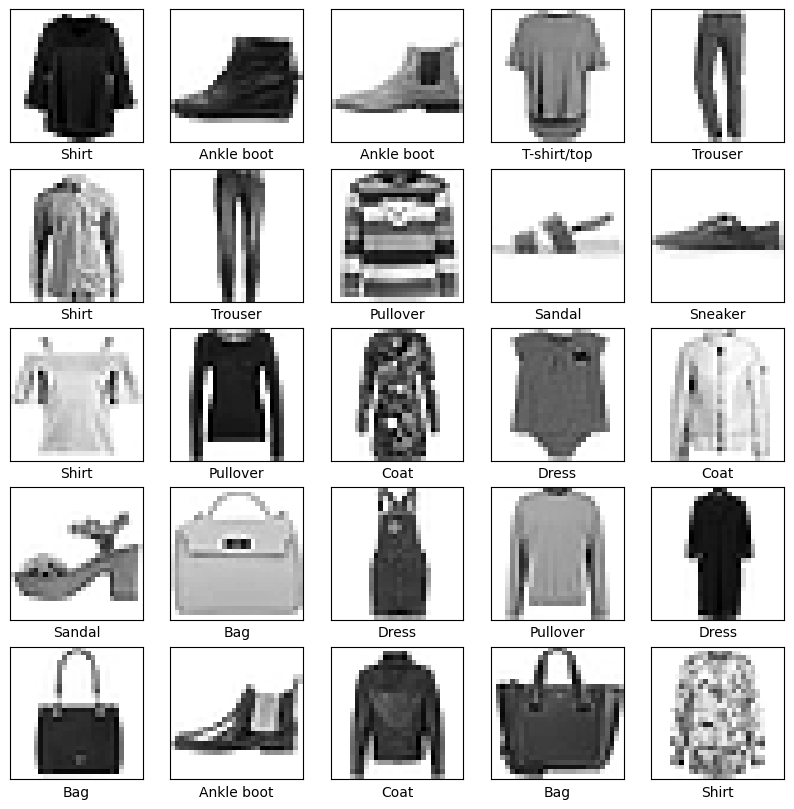

In [4]:
for images, labels in ds_train.take(1):
    show(images.numpy(), labels.numpy())

In [5]:
# Modelo del CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10) # numero de clases en Fashion MNIST
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 33ms/step - accuracy: 0.7814 - loss: 0.6080 - val_accuracy: 0.8798 - val_loss: 0.3363
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.8849 - loss: 0.3136 - val_accuracy: 0.8957 - val_loss: 0.2881
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.9064 - loss: 0.2548 - val_accuracy: 0.9008 - val_loss: 0.2700
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.9179 - loss: 0.2210 - val_accuracy: 0.8999 - val_loss: 0.2690
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9286 - loss: 0.1910 - val_accuracy: 0.9061 - val_loss: 0.2521
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9390 - loss: 0.1649 - val_accuracy: 0.9030 - val_loss: 0.2734
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 57s 31ms/step - accuracy: 0.9446 - loss: 0.1476 - val_accuracy: 0.9091 - val_loss: 0.2576
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9501 - loss: 0.13

In [6]:
# Evaluar el modelo
loss, accuracy = model.evaluate(ds_test, verbose=2)
print(f'Precisión en el conjunto de prueba: {accuracy}')

313/313 - 2s - 8ms/step - accuracy: 0.9135 - loss: 0.2984
Precisión en el conjunto de prueba: 0.9135000109672546


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


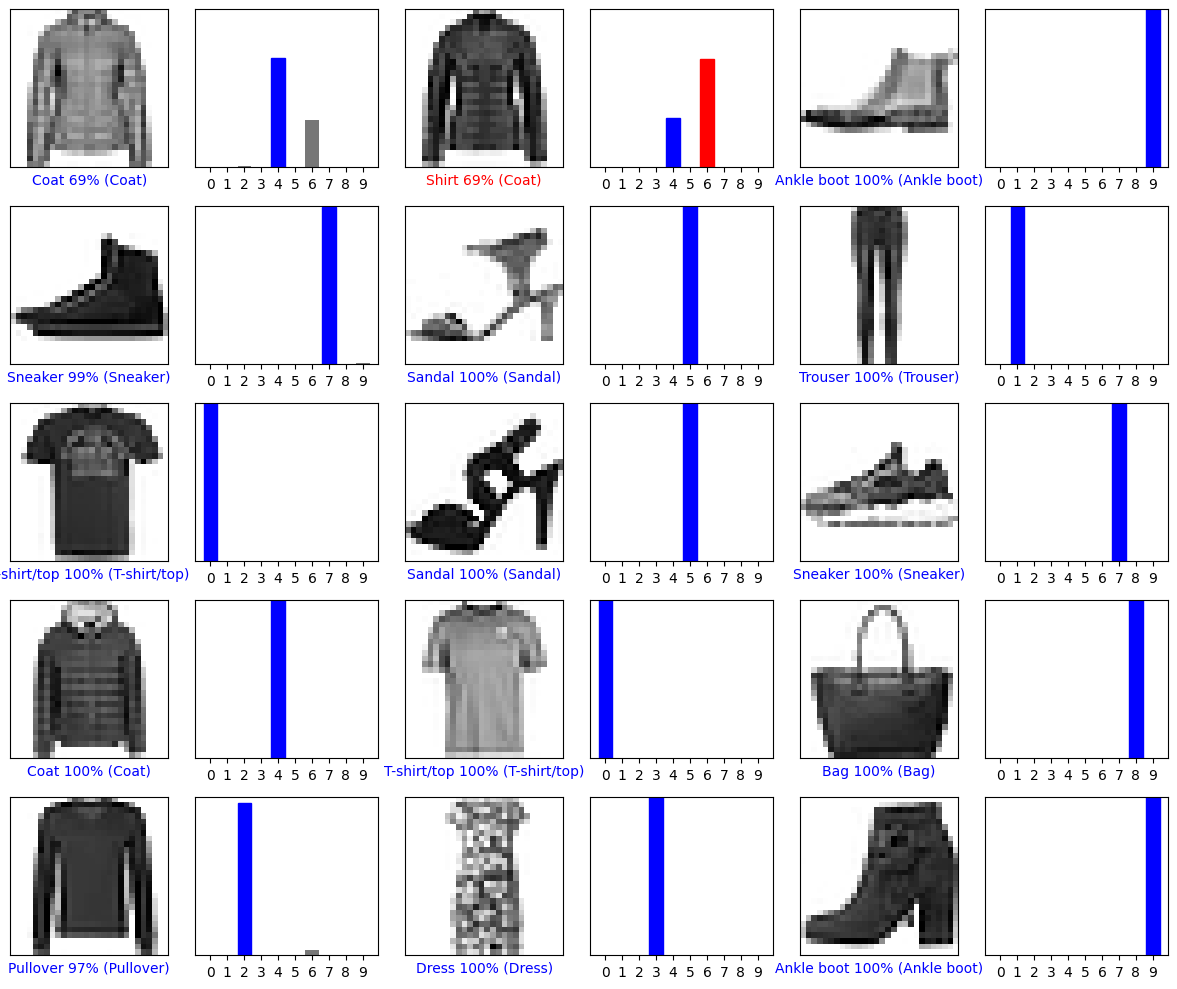

In [8]:
# Predicciones del modelo

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
test_images_batch, test_labels_batch = next(iter(ds_test))
predictions = probability_model.predict(test_images_batch)

def plot_image(i, predictions_array, true_label, img, class_names):
    true_label = true_label[i]
    predicted_label = tf.argmax(predictions_array[i])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[i], cmap=plt.cm.binary)

    predicted_label = tf.argmax(predictions_array[i])
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*tf.reduce_max(predictions_array[i]),
                                class_names[true_label]),
                                color=color)


def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[i], color="#777777")
    plt.ylim([0, 1])
    predicted_label = tf.argmax(predictions_array[i])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels_batch.numpy(), test_images_batch.numpy(), class_names)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels_batch.numpy())
plt.tight_layout()
plt.show()

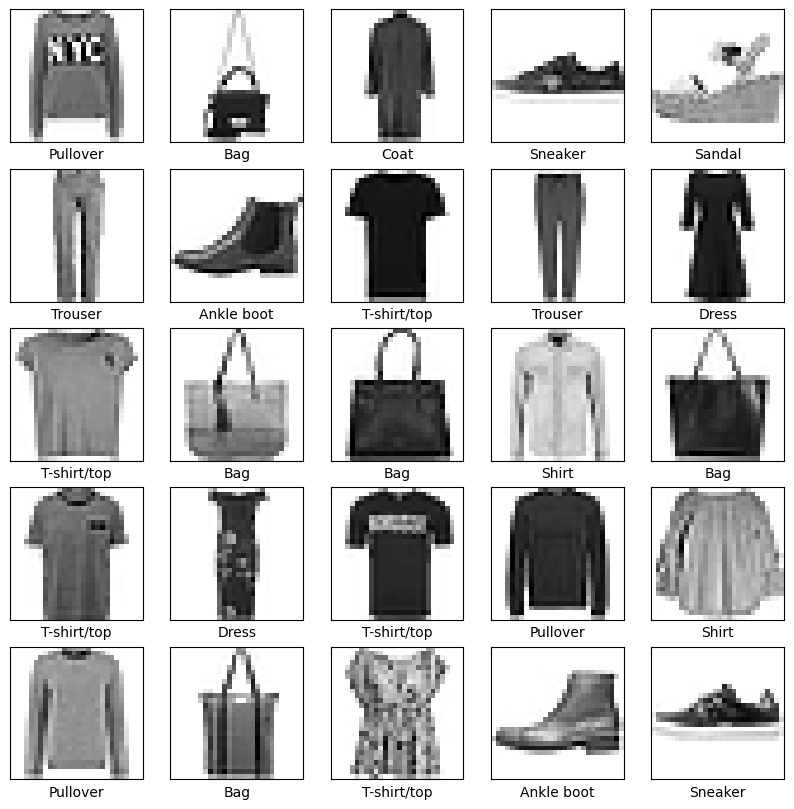

In [9]:
# Imagenes usadas
for images, labels in ds_train.take(1):
    show(images.numpy(), labels.numpy())